In [ ]:
!pip install wget

In [ ]:
#import wget
import os
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np

In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks/RecSys')

In [ ]:
#wget.download('https://recsys2019data.trivago.com/train.csv')

In [ ]:
df = pd.read_csv('data/train.csv')

In [ ]:
df.head(15)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
5,00RL8Z82B2Z1,aff3928535f48,1541037532,6,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
6,00RL8Z82B2Z1,aff3928535f48,1541037532,7,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
7,00RL8Z82B2Z1,aff3928535f48,1541037532,8,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
8,00RL8Z82B2Z1,aff3928535f48,1541037542,9,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
9,00RL8Z82B2Z1,aff3928535f48,1541037542,10,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [ ]:
salary = pd.read_csv('data/salaries_with_domains.csv', index_col=0)

In [ ]:
salary.set_index('Data Source', inplace = True)
salary = salary.to_dict()['2019.0']
df['salaries'] = df.platform
df['salaries'] = df.salaries.map(salary)
list_nf = df[df.salaries.isna()].platform.value_counts().index.to_list()

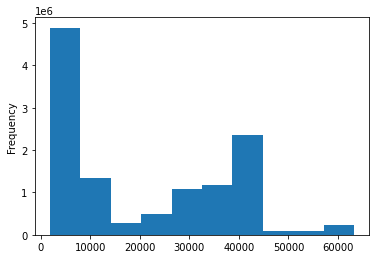

In [ ]:
df['salaries'].plot.hist()

In [ ]:
check_ = df.salaries.fillna(df.salaries.median())
df['salary'] = check_

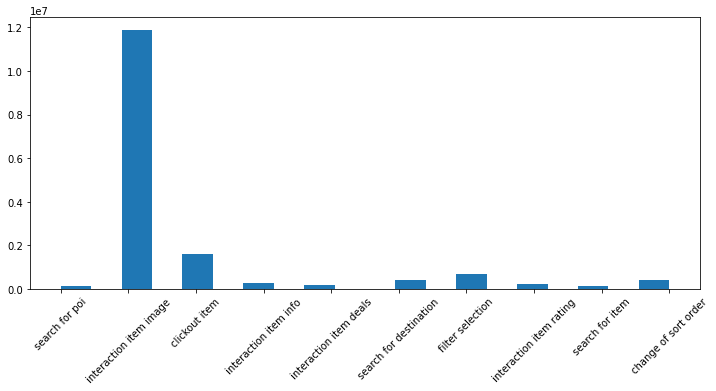

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.hist(df.action_type, bins=20)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
df.isnull().sum()

user_id                   0
session_id                0
timestamp                 0
step                      0
action_type               0
reference                 0
platform                  0
city                      0
device                    0
current_filters    14779880
impressions        14346406
prices             14346406
salaries            3893385
salary                    0
dtype: int64

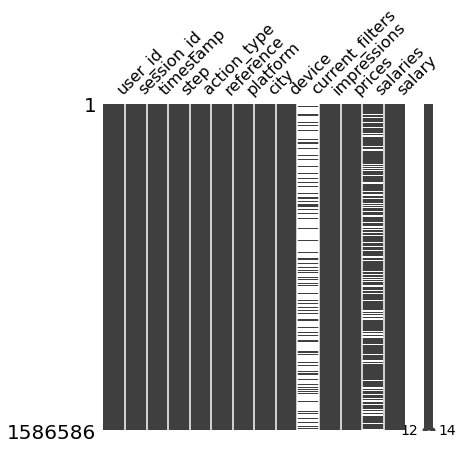

In [ ]:
msno.matrix(df.loc[df['action_type'] == 'clickout item'], figsize=(6,6)) 

Feature creation

In [ ]:
def checkpoint(df, save_as):
        df.to_csv(save_as, mode = 'a', header = False)

In [ ]:
def create_features(df, submission_mode=False, save_as = 'all_features.csv'):
  # Строки с типом действия - клик'
  clickout_rows_df = df[df['action_type'] == 'clickout item']


  if len(clickout_rows_df) > 0:
    # Словарь признаков для прогонки через нейронку
    features = {
            # Признаки по текущему imr в итерации
            'imp_appeared': [],           # количество появлений текущего impr
            
            'time_passed_imp_app': [],    # время прошедшее после последнего 
                                          # появления текущего impr в списке 
                                          # reference всей сессии
            
            'filter_changed' : [],        # количество измененных фильтров
            
            'price_per_salary' : [],      # отношение цены текущего impr к з/п
            
            's_last_imp_app': [],         # количество проделанных шагов 
                                          # (действий) после последнего появления 
                                          # текущего impr в reference сессии
            
            'last_actions_part_impr': [], # тип действия во время последнего 
                                          # появления текущего impr в 
                                          # reference сессии
            
            'imp_pos': [],                # позиция текущего impr в 
                                          # списке impressions
            
            'label': [],                  # target label reference последнего 
                                          # клика, который необходимо предсказать
            
            'price': [],                  # цена
            
            'sorted_price_pos': [],       # позиция цены в отсортированном 
                                          # списке цен для последнего клика
            
            # Постоянные признаки по сессии юзера
            'time_session': [],           # длина сессии
            
            's_s': [],                    # количество шагов в сессии
            
            'last_act_time': [],          # время после последнего клика в сессии
            
            'reference_last_act': [],     # позиция последнего reference в сессии 
                                          # в списке impressions последнего 
                                          # клика в сессии

            'index': []                   # индекс последнего клика 
                                          # в сессии в датафрейме
                }
        
    clk = clickout_rows_df.tail(1) # переменная target клика в сессии
    filter_changed = clk['current_filters'].nunique() # количество смены 
                                                      # фильтров за сессию

    # обрезаем фрейм от начала сессии до последнего клика в сессии
    df = df.loc[df.head(1).index.values[0]:clk.index.values[0] - 1]


    if df.shape[0] > 0:
      sess_time = clk['timestamp'].values[0] - df.loc[0, 'timestamp']
      last_act_time = clk['timestamp'].values[0] - df.loc[-1, 'timestamp']
            
      # проверка последнего reference в сессии
      if df.loc[-1, 'reference'].isdigit():
        last_ref = int(df.loc[-1, 'reference'])
      else:
        last_ref = 0
    else:
      sess_time = -0.5
      last_act_time = -0.5
      last_ref = -0.5
    session_steps = clk['step'].values[0]

    # список impressions последнего клика в сессии
    impr = list(map(int, clk['impressions'].values[0].split('|')))

    # проверка есть ли последний reference сессии в списке impr последнего клика
    if last_ref in impr:
      reference_last_act = impr.index(last_ref)
    else:
      reference_last_act = -0.5

    prices = list(map(int, clk['prices'].values[0].split('|')))
    salary_ = clk['salary'].values[0]
    sorted_prices = prices.copy()
    sorted_prices.sort()

    references = df['reference'].values

        
    for count, i in enumerate(impr):
      indices = np.where(references == str(i))[0]  # список из индексов
                              # каждый из которого указывает на положение текущего
                              # impression (i) в списке всех reference сессии
            
      features['index'].append(clk.index[0])  # индекс последнего клика в сессии
      features['imp_pos'].append(count + 1)  # позиция текущего impr (i)
      features['price'].append(prices[count])  # цена текущего impr
      features['price_per_salary'].append(prices[count] / salary_)  # отношение 
                                                          # текущей цены к з/п
      features['sorted_price_pos'].append(sorted_prices.index(prices[count])) #\
                                # индекс текущей цены в отсортированном списке

      # Проверка, есть ли хотя бы одно появление текущего impr в reference сессии
      if len(indices) > 0:
        row_reference = df.head(indices[-1] + 1).tail(1)  # строка с последним появлением текущего impr в reference сессии
        features['s_last_imp_app'].append(len(df) - indices[-1])  # количество шагов 
                            # после последнего появления текущего impr в списке references
        features['time_passed_imp_app'].append(
                    int(clk['timestamp'].values[0] - row_reference['timestamp'].values[0])) # время между
                          # последним кликом в сессии и последним появлением текущего imr
        features['last_actions_part_impr'].append(
                    row_reference['action_type'].values[0])  # тип действия во 
                          # время последнего появления текущего impr в reference сессии 
      else:
        features['s_last_imp_app'].append(
                    -0.5) 
        features['time_passed_imp_app'].append(
                    -0.5) 
        features['last_actions_part_impr'].append(
                    'no_action') 
      features['imp_appeared'].append(len(indices)) # количество появлений 
            # текущего impr в списке всех reference сессии
      features['time_session'].append(sess_time) # время длительности сессии
      features['s_s'].append(session_steps) # количество шагов в сессии
      features['last_act_time'].append(last_act_time) # время между 
                    # последним событием в сессии и последним кликом в сессии
      features['reference_last_act'].append(reference_last_act) # позиция
                    # последнего reference в сессии в списке impressions последнего клика
      features['filter_changed'].append(filter_changed)  # смена фильтров
      
      # задаем таргетовую переменную для последнего клика, 
      # 1 - если текущий impr совпадает с reference, 0- если нет
      if int(clk['reference'].values[0]) == i:
        features['label'].append(1)
      else:
        features['label'].append(0)

    # заполним нулями недостающие значения
    num_miss = 25 - len(impr)
    if num_miss > 0:
      for k in features.keys():
        if k == 'label':
          features[k].extend(np.zeros(num_miss))
        else:
          features[k].extend(np.ones(num_miss) * -1)
        
    checkpoint(pd.DataFrame(features), save_as) # сохраним обработанную часть даты

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()
df.groupby(['user_id', 'session_id']).progress_apply(create_features)

Some cosmetics procedures

In [ ]:
data = pd.read_csv('all_features.csv')

In [ ]:
features = ['idx',
            'imp_appeared', 
            'time_passed_imp_app', 
            'filter_changed',
            'price_per_salary',
            's_last_imp_app', 
            'last_actions_part_impr', 
            'imp_pos':, 
            'label', 
            'price', 
            'sorted_price_pos',
            'time_session', 
            's_s', 
            'last_act_time', 
            'reference_last_act',
            'index'] 

In [ ]:
row = [0,
 0.0,
 -0.5,
 1.0,
 0.00619083641766382,
 -0.5,
 'no_action',
 1.0,
 0.0,
 47.0,
 3.0,
 472.0,
 17.0,
 69.0,
 -0.5,
 8321598.0]

In [ ]:
data.loc[-1] = row
data.index = data.index + 1
data.sort_index(inplace=True) 

In [ ]:
data.columns = features

In [ ]:
data.to_csv('finished_data.csv')

Dataset creation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [ ]:
df_features = pd.read_csv('finished_data.csv')

In [ ]:
df_features.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_features.head(25)

In [ ]:
X, Y = df_features.iloc[:, [1, 2, 4, 5, 7, 9]], df_features.iloc[:, 8]

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_norm = scaler.fit_transform(X)
Y_norm = Y.values

In [ ]:
print('Data shuffling')
X_norm_shuffled = []
Y_norm_shuffled = []
for i in tqdm(range(0, X_norm.shape[0], 25)):
    x, y = shuffle(X_norm[i:i + 25], Y_norm[i:i + 25])
    X_norm_shuffled.append(x)
    Y_norm_shuffled.append(y)

In [ ]:
data_train = np.array(X_norm_shuffled)
labels = np.array(Y_norm_shuffled)

In [ ]:
import pickle
with open('data_train.pkl','wb') as f:
  pickle.dump(data_train, f)
with open('labels.pkl','wb') as f:
  pickle.dump(labels, f)